In [1]:
import os
import conda

conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import Normalize
from scipy.interpolate import griddata


In [2]:
# set plot styles
#plt.style.use('classic')
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 21})

In [3]:
# load data
KLB1=pd.read_excel('Data/Compiled melting experiments no low P.xls', sheet_name='KLB1')
MIX1g=pd.read_excel('Data/Compiled melting experiments no low P.xls', sheet_name='MIX1g')
KLB1_TC=pd.read_csv('Thermocalc_files/tc_tcgrid_KLB1_Matt.csv')
MIX1g_TC=pd.read_csv('Thermocalc_files/tc_tcgrid_MIX1G_Matt.csv')
KLB1_TC=KLB1_TC.dropna(how='all')
MIX1g_TC=MIX1g_TC.dropna(how='all')
Comp = pd.read_excel('Data/Compiled data2.xlsx')
Filt = pd.read_excel('Data/Compiled data filtered3.xlsx')
Ol = pd.read_excel('Data/OlivineComp.xlsx')
OlModel = pd.read_excel('Data/OlivineModel.xlsx')
norm = Normalize()

X1=np.array([-92,-91.5,-91,-90.7,-90.4,-90.2,-90])
Y1=np.array([0.2,0.2,-0.05,-.25,-0.55,-1,-1.5])
p=np.polyfit(X1,Y1,3)

X=np.linspace(-92,-90,1001)
Y=p[0]*X**3+p[1]*X**2+p[2]*X+p[3]#-0.6*(X**2)-110*X-5041.4

a=np.zeros(len(Filt['Long']))
for i in range(0, len(Filt['Long'])):
    b=10**9
    for j in range(0,len(Y)):
        d=np.sqrt((Filt['Long'].loc[i]-X[j])**2+(Filt['Lat'].loc[i]-Y[j])**2)
        if d<b:
            b=d
    
    a[i]=b
        
c=np.zeros(len(Filt['Long']))
for i in range(0,len(Filt['Long'])):
    if Filt['Lat'].loc[i]>Y[np.abs(X-Filt['Long'].loc[i]).argmin()]:
        c[i]=-1
    else:
        c[i]=1

Filt['Dis']=a*110*c

a=np.zeros(len(Comp['Long']))
for i in range(0, len(Comp['Long'])):
    b=10**9
    for j in range(0,len(Y)):
        d=np.sqrt((Comp['Long'].loc[i]-X[j])**2+(Comp['Lat'].loc[i]-Y[j])**2)
        if d<b:
            b=d
    
    a[i]=b
        
c=np.zeros(len(Comp['Long']))
for i in range(0,len(Comp['Long'])):
    if Comp['Lat'].loc[i]>Y[np.abs(X-Comp['Long'].loc[i]).argmin()]:
        c[i]=-1
    else:
        c[i]=1

Comp['Dis']=a*110*c

Ol['Fo']=(Ol.MgO.values/40.3044)/(Ol.MgO.values/40.3044+Ol.FeO.values/71.844)*100
Ol['Ni']=10000*Ol.NiO.values*58.7/74.7
Ol['FeMn']=(Ol.FeO.values/71.844)/(Ol.MnO.values/70.9)

# set colour for plots
Santiago1='darkblue'
Santiago2='cyan'
SantaCruz='paleturquoise'
Floreana='orangered'
Fernandina='red'
East='gold'
NorthernIsabela='cadetblue'
SouthernIsabela='indianred'

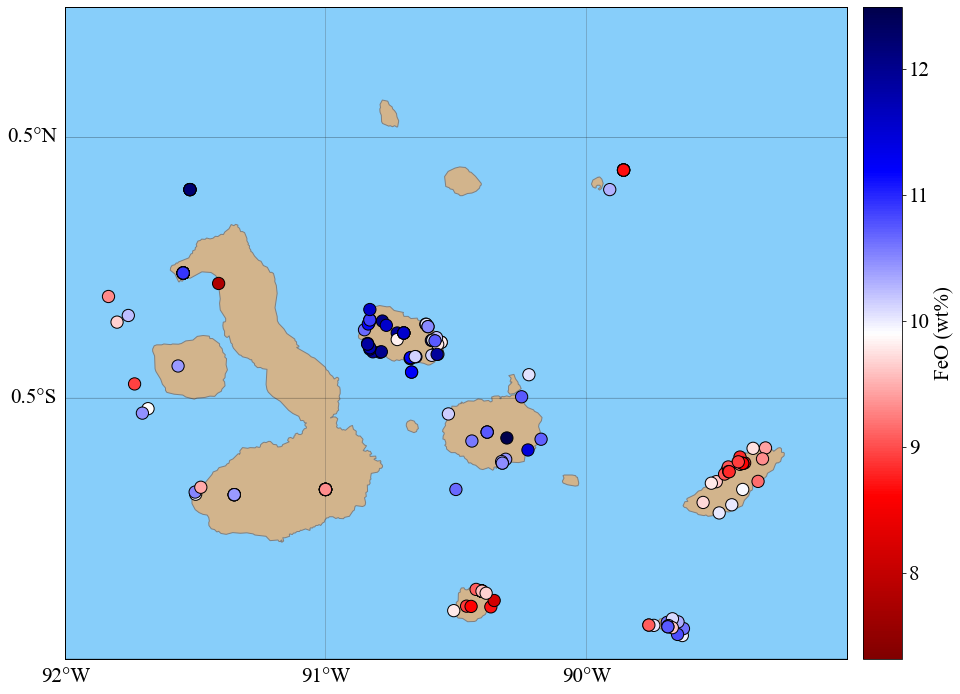

In [4]:
# set up plot
#plt.clf()
#fig = plt.figure(figsize=(10, 8))
#ax = fig.add_subplot(111, frame_on=False)

# define map extent
lllon = -92
lllat = -1.5
urlon = -89
urlat = 1

fig = plt.figure(figsize=(15, 12))
# Set up Basemap instance
m = Basemap(
    projection = 'merc',
    llcrnrlon = lllon, llcrnrlat = lllat, urcrnrlon = urlon, urcrnrlat = urlat,
    resolution='h')

#transform
Filt['projected_lon'], Filt['projected_lat'] = m(*(Filt.Long.values, Filt.Lat.values))

# grid data
numcols, numrows = 1000, 1000
xi = np.linspace(Filt['projected_lon'].min(), Filt['projected_lon'].max(), numcols)
yi = np.linspace(Filt['projected_lat'].min(), Filt['projected_lat'].max(), numrows)
xi, yi = np.meshgrid(xi, yi)

# interpolate
x, y, z = Filt['projected_lon'].values, Filt['projected_lat'].values, Filt.FeO.values
arr=np.array([x,y])
arr=arr.reshape(len(x),2)
zi = griddata(arr, z, (xi, yi), method='cubic')

# draw map
m.drawcoastlines(color='gray')
m.drawmapboundary(fill_color='lightskyblue')
m.fillcontinents(color='tan',lake_color='lightskyblue')

m.drawparallels(
    np.arange(lllat, urlat, 1),
    color = 'black', linewidth = 0.5,
    labels=[True, False, False, False])
m.drawmeridians(
    np.arange(lllon, urlon, 1),
    color = '0.25', linewidth = 0.5,
    labels=[False, False, False, True])

sc=m.scatter(Filt['projected_lon'],Filt['projected_lat'],marker='o',
    c=(Filt['FeO']),#-min(Filt['FeO']))/(max(Filt['FeO'])-min(Filt['FeO'])),
    alpha=1,
    s=150, zorder=4,cmap='seismic_r',edgecolors='k')

# add colour bar, title, and scale
cbar=m.colorbar(sc)#
cbar.set_label("FeO (wt%)")

plt.savefig('Map_FeO.eps', format='eps')

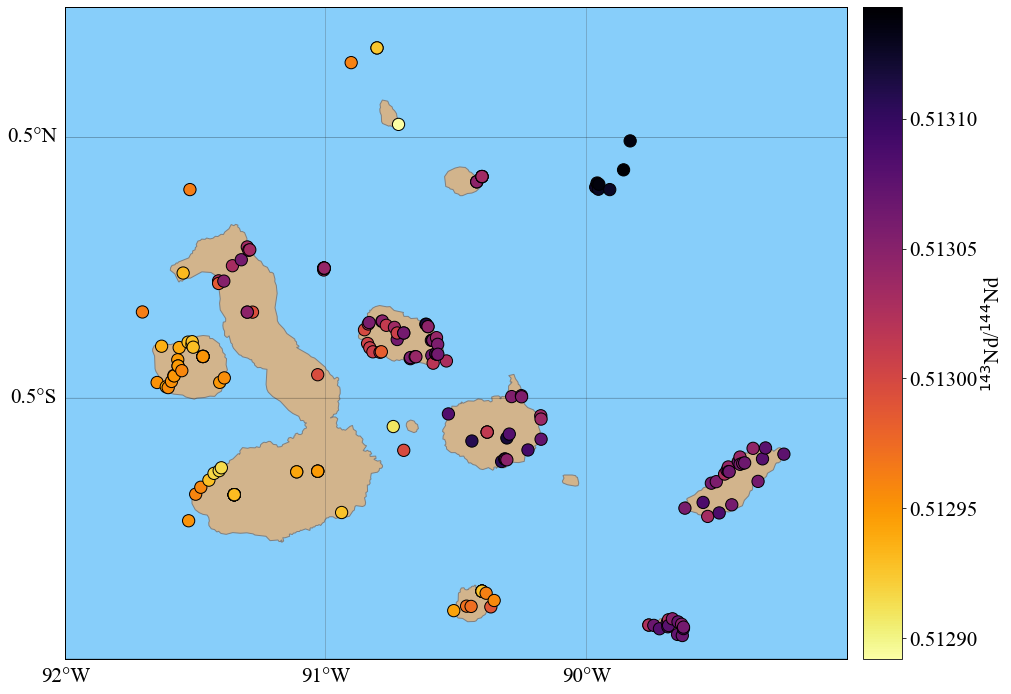

In [5]:
# isotope plot
fig = plt.figure(figsize=(15, 12))
m2 = Basemap(
    projection = 'merc',
    llcrnrlon = lllon, llcrnrlat = lllat, urcrnrlon = urlon, urcrnrlat = urlat,
    resolution='h')

m2.drawcoastlines(color='gray')
m2.drawmapboundary(fill_color='lightskyblue')
m2.fillcontinents(color='tan',lake_color='lightskyblue')

Comp['projected_lon'], Comp['projected_lat'] = m2(*(Comp.Long.values, Comp.Lat.values))

m2.drawparallels(
    np.arange(lllat, urlat, 1),
    color = 'black', linewidth = 0.5,
    labels=[True, False, False, False])
m2.drawmeridians(
    np.arange(lllon, urlon, 1),
    color = '0.25', linewidth = 0.5,
    labels=[False, False, False, True])

sc=m2.scatter(Comp['projected_lon'],Comp['projected_lat'],marker='o',
    c=(Comp['Nd143']),#-min(Comp['Nd143']))/(max(Comp['Nd143'])-min(Comp['Nd143'])),
    alpha=1,
    s=150, zorder=4,cmap='inferno_r',edgecolors='k') #seismic_r'

# add colour bar, title, and scale
cbar=m2.colorbar(sc)#
cbar.set_label("$^{143}$Nd/$^{144}$Nd")

FeMn=(Filt.FeO.values/71.844)/(Filt.MnO.values/70.9)
FeMn[(FeMn > 80)|(FeMn<45)] = np.nan
Filt['FeMn']=FeMn

plt.savefig('Map_Nd143.eps', format='eps')


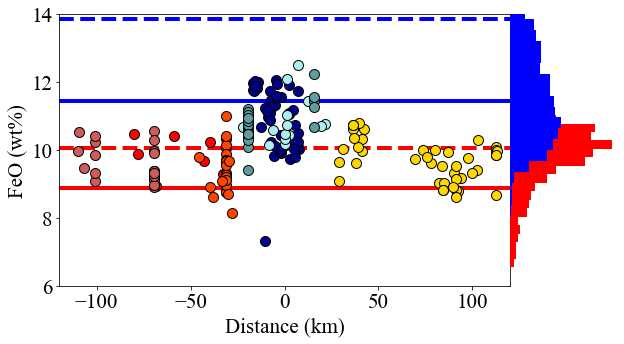

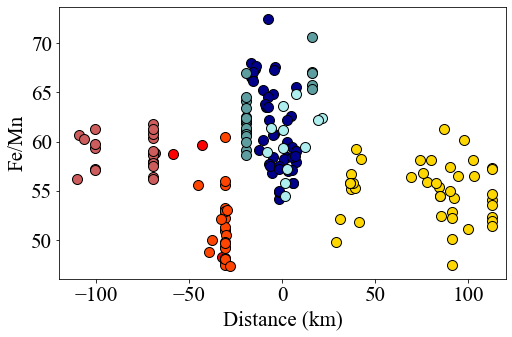

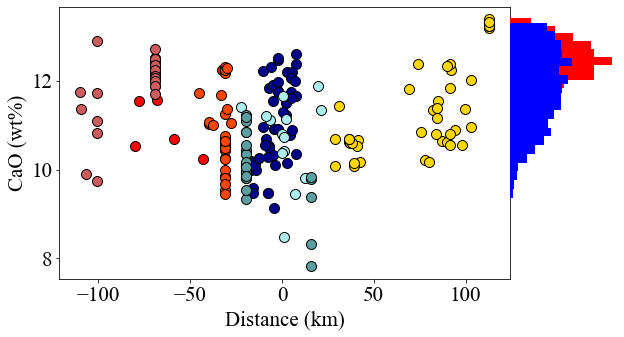

In [6]:
# plot longitudinal plots

Oxide=['CaO','SiO2','Cr2O3','TiO2','FeO','K2O','MgO','Na2O','Al2O3']
d=[56.0774,60.08,151.99,79.866,71.844,94.2,40.3044,61.9789,101.96]
df2 = pd.DataFrame(data=d,index=Oxide)
KLB1_TC['sum']=np.zeros(len(KLB1_TC['liq_FeO']))

for ox in Oxide:
    #print('liq_'+ox)
    #a='liq_'+1
    KLB1_TC['wt_'+ox]=KLB1_TC['liq_'+ox]*df2.loc[ox].values
    KLB1_TC['sum']=KLB1_TC['sum']+KLB1_TC['wt_'+ox]
    
for ox in Oxide:
    KLB1_TC[ox+'wt']=KLB1_TC['wt_'+ox]/KLB1_TC['sum']*100
    
MIX1g_TC['sum']=np.zeros(len(MIX1g_TC['liq_FeO']))

for ox in Oxide:
    #print('liq_'+ox)
    #a='liq_'+1
    MIX1g_TC['wt_'+ox]=MIX1g_TC['liq_'+ox]*df2.loc[ox].values
    MIX1g_TC['sum']=MIX1g_TC['sum']+MIX1g_TC['wt_'+ox]
    
for ox in Oxide:
    MIX1g_TC[ox+'wt']=MIX1g_TC['wt_'+ox]/MIX1g_TC['sum']*100

fig, ((ax3a),(ax3b)) = plt.subplots(1, 2, figsize=(10,5),gridspec_kw={'width_ratios': [4.2, 1]})
plt.subplots_adjust(wspace=0, hspace=0)
ax3a.plot([-120,120],[np.mean(MIX1g.FeO.values),np.mean(MIX1g.FeO.values)],'-b',linewidth=4)
ax3a.plot([-120,120],[np.max(MIX1g.FeO.values),np.max(MIX1g.FeO.values)],'--b',linewidth=4)

ax3a.plot([-120,120],[np.mean(KLB1.FeO.values),np.mean(KLB1.FeO.values)],'-r',linewidth=4)
ax3a.plot([-120,120],[np.max(KLB1.FeO.values),np.max(KLB1.FeO.values)],'--r',linewidth=4)

ax3a.plot(-Filt.Dis[(Filt.Loc=="Santiago")|(Filt.Loc=="Rabida")],Filt.FeO[(Filt.Loc=="Santiago")|(Filt.Loc=="Rabida")],'ok',markerfacecolor=Santiago1,markersize=10)
ax3a.plot(-Filt.Dis[(Filt.Loc=="Santa Cruz")|(Filt.Loc=="Santa Fe")],Filt.FeO[(Filt.Loc=="Santa Cruz")|(Filt.Loc=="Santa Fe")],'ok',markerfacecolor=SantaCruz,markersize=10)
ax3a.plot(-Filt.Dis[Filt.Loc=="Fernandina"],Filt.FeO[Filt.Loc=="Fernandina"],'ok',markerfacecolor=Fernandina,markersize=10)
ax3a.plot(-Filt.Dis[(Filt.Loc=="San Cristobal")|(Filt.Loc=="Espanola")|(Filt.Loc=="Genovesa")],Filt.FeO[(Filt.Loc=="San Cristobal")|(Filt.Loc=="Espanola")|(Filt.Loc=="Genovesa")],'ok',markerfacecolor=East,markersize=10)
ax3a.plot(-Filt.Dis[(Filt.Loc=="Sierra Negra")|(Filt.Loc=="Cerro Azul")],Filt.FeO[(Filt.Loc=="Cerro Azul")|(Filt.Loc=="Sierra Negra")],'ok',markerfacecolor=SouthernIsabela,markersize=10)
ax3a.plot(-Filt.Dis[(Filt.Loc=="Roca")|(Filt.Loc=="Ecuador")],Filt.FeO[(Filt.Loc=="Roca")|(Filt.Loc=="Ecuador")],'ok',markerfacecolor=NorthernIsabela,markersize=10)
ax3a.plot(-Filt.Dis[(Filt.Loc=="Floreana")],Filt.FeO[(Filt.Loc=="Floreana")],'ok',markerfacecolor=Floreana,markersize=10)

ax3a.set_ylabel('FeO (wt%)')
ax3a.set_xlabel('Distance (km)')
ax3a.invert_xaxis()
ax3a.set_ylim([6,14])
ax3a.set_xlim([-120,120])

KLB1_FeO=KLB1_TC.FeOwt.values[(KLB1_TC.liq<0.2) & (KLB1_TC.pressure > 15) & (KLB1_TC.pressure < 30)]
ax3b.hist(KLB1_FeO,density=1,orientation='horizontal',color='red',bins=20)

MIX1G_FeO=MIX1g_TC.FeOwt.values[(MIX1g_TC.liq<0.6) & (MIX1g_TC.pressure > 15)]
ax3b.hist(MIX1G_FeO,density=1,orientation='horizontal',color='blue',bins=20)

ax3b.axes.get_xaxis().set_visible(False)
ax3b.axes.get_yaxis().set_visible(False)
ax3b.set_ylim([6,14])
ax3b.axis("off")

plt.savefig('Long_FeO.eps', format='eps')

#fig, ((ax3b)) = plt.subplots(1, 1, figsize=(8,5))
#ax3b.hist(KLB1.FeO)
#ax3b.hist(MIX1g.FeO)

fig, ((ax4a)) = plt.subplots(1, 1, figsize=(8,5))
ax4a.plot(-Filt.Dis[(Filt.Loc=="Santiago")|(Filt.Loc=="Rabida")],Filt.FeMn[(Filt.Loc=="Santiago")|(Filt.Loc=="Rabida")],'ok',markerfacecolor=Santiago1,markersize=10)
ax4a.plot(-Filt.Dis[(Filt.Loc=="Santa Cruz")|(Filt.Loc=="Santa Fe")],Filt.FeMn[(Filt.Loc=="Santa Cruz")|(Filt.Loc=="Santa Fe")],'ok',markerfacecolor=SantaCruz,markersize=10)
ax4a.plot(-Filt.Dis[Filt.Loc=="Fernandina"],Filt.FeMn[Filt.Loc=="Fernandina"],'ok',markerfacecolor=Fernandina,markersize=10)
ax4a.plot(-Filt.Dis[(Filt.Loc=="San Cristobal")|(Filt.Loc=="Espanola")|(Filt.Loc=="Genovesa")],Filt.FeMn[(Filt.Loc=="San Cristobal")|(Filt.Loc=="Espanola")|(Filt.Loc=="Genovesa")],'ok',markerfacecolor=East,markersize=10)
ax4a.plot(-Filt.Dis[(Filt.Loc=="Sierra Negra")|(Filt.Loc=="Cerro Azul")],Filt.FeMn[(Filt.Loc=="Cerro Azul")|(Filt.Loc=="Sierra Negra")],'ok',markerfacecolor=SouthernIsabela,markersize=10)
ax4a.plot(-Filt.Dis[(Filt.Loc=="Roca")|(Filt.Loc=="Ecuador")],Filt.FeMn[(Filt.Loc=="Roca")|(Filt.Loc=="Ecuador")],'ok',markerfacecolor=NorthernIsabela,markersize=10)
ax4a.plot(-Filt.Dis[(Filt.Loc=="Floreana")],Filt.FeMn[(Filt.Loc=="Floreana")],'ok',markerfacecolor=Floreana,markersize=10)

ax4a.set_ylabel('Fe/Mn')
ax4a.set_xlabel('Distance (km)')
ax4a.invert_xaxis()
ax4a.set_xlim([-120,120])

plt.savefig('Long_FeMn.eps', format='eps')

fig, ((ax5a),(ax5b)) = plt.subplots(1, 2, figsize=(10,5),gridspec_kw={'width_ratios': [4.2, 1]})
plt.subplots_adjust(wspace=0, hspace=0)

ax5a.plot(-Filt.Dis[(Filt.Loc=="Santiago")|(Filt.Loc=="Rabida")],Filt.CaO[(Filt.Loc=="Santiago")|(Filt.Loc=="Rabida")],'ok',markerfacecolor=Santiago1,markersize=10)
ax5a.plot(-Filt.Dis[(Filt.Loc=="Santa Cruz")|(Filt.Loc=="Santa Fe")],Filt.CaO[(Filt.Loc=="Santa Cruz")|(Filt.Loc=="Santa Fe")],'ok',markerfacecolor=SantaCruz,markersize=10)
ax5a.plot(-Filt.Dis[Filt.Loc=="Fernandina"],Filt.CaO[Filt.Loc=="Fernandina"],'ok',markerfacecolor=Fernandina,markersize=10)
ax5a.plot(-Filt.Dis[(Filt.Loc=="San Cristobal")|(Filt.Loc=="Espanola")|(Filt.Loc=="Genovesa")],Filt.CaO[(Filt.Loc=="San Cristobal")|(Filt.Loc=="Espanola")|(Filt.Loc=="Genovesa")],'ok',markerfacecolor=East,markersize=10)
ax5a.plot(-Filt.Dis[(Filt.Loc=="Sierra Negra")|(Filt.Loc=="Cerro Azul")],Filt.CaO[(Filt.Loc=="Cerro Azul")|(Filt.Loc=="Sierra Negra")],'ok',markerfacecolor=SouthernIsabela,markersize=10)
ax5a.plot(-Filt.Dis[(Filt.Loc=="Roca")|(Filt.Loc=="Ecuador")],Filt.CaO[(Filt.Loc=="Roca")|(Filt.Loc=="Ecuador")],'ok',markerfacecolor=NorthernIsabela,markersize=10)
ax5a.plot(-Filt.Dis[(Filt.Loc=="Floreana")],Filt.CaO[(Filt.Loc=="Floreana")],'ok',markerfacecolor=Floreana,markersize=10)

ax5a.set_ylabel('CaO (wt%)')
ax5a.set_xlabel('Distance (km)')

KLB1_CaO=KLB1_TC.CaOwt.values[(KLB1_TC.liq<0.2) & (KLB1_TC.pressure > 17) & (KLB1_TC.pressure < 30)]
ax5b.hist(KLB1_CaO,density=1,orientation='horizontal',color='red',bins=20)

MIX1G_CaO=MIX1g_TC.CaOwt.values[(MIX1g_TC.liq<0.6) & (MIX1g_TC.pressure > 17)]
ax5b.hist(MIX1G_CaO,density=1,orientation='horizontal',color='blue',bins=20)

ax5b.axes.get_xaxis().set_visible(False)
ax5b.axes.get_yaxis().set_visible(False)
ax5b.set_ylim([7,14])
ax5b.axis("off")

plt.savefig('Long_CaO.eps', format='eps')

Test=np.zeros(len(KLB1_TC.FeOwt.values))


In [7]:
Test=np.zeros(len(Filt.FeO[(Filt.Loc=="San Cristobal")|(Filt.Loc=="Espanola")|(Filt.Loc=="Genovesa")|(Filt.Loc=="Cerro Azul")|(Filt.Loc=="Sierra Negra")|(Filt.Loc=="Floreana")|(Filt.Loc=="Fernandina")]))+1
Test=Test/sum(Test)
n=5000000
Res=np.random.choice(Filt.FeO[(Filt.Loc=="San Cristobal")|(Filt.Loc=="Espanola")|(Filt.Loc=="Genovesa")|(Filt.Loc=="Cerro Azul")|(Filt.Loc=="Sierra Negra")|(Filt.Loc=="Floreana")|(Filt.Loc=="Fernandina")],n,p=Test)
MeanRes=np.mean(Res)
Res=np.sort(Res)
LowError=MeanRes-Res[int(n*0.05)]
HighError=Res[int(n*0.95)]-MeanRes
print('SWE Galapagos - ','Mean:',MeanRes,'| Negative Error:',LowError,'| Positive Error:',HighError)

Test=np.zeros(len(KLB1_FeO))+1
Test=Test/sum(Test)
Res=np.random.choice(KLB1_FeO,n,p=Test)
MeanRes=np.mean(Res)
Res=np.sort(Res)
LowError=MeanRes-Res[int(n*0.05)]
HighError=Res[int(n*0.95)]-MeanRes
print('KLB-1 - ','Mean:',MeanRes,'| Negative Error:',LowError,'| Positive Error:',HighError)

Test=np.zeros(len(Filt.FeO[(Filt.Loc=="Santiago")|(Filt.Loc=="Rabida")|(Filt.Loc=="Santa Cruz")|(Filt.Loc=="Santa Fe")|(Filt.Loc=="Roca")|(Filt.Loc=="Ecuador")]))+1
Test=Test/sum(Test)
Res=np.random.choice(Filt.FeO[(Filt.Loc=="Santiago")|(Filt.Loc=="Rabida")|(Filt.Loc=="Santa Cruz")|(Filt.Loc=="Santa Fe")|(Filt.Loc=="Roca")|(Filt.Loc=="Ecuador")],n,p=Test)
MeanRes=np.mean(Res)
Res=np.sort(Res)
LowError=MeanRes-Res[int(n*0.05)]
HighError=Res[int(n*0.95)]-MeanRes
print('N-C Galapagos - ','Mean:',MeanRes,'| Negative Error:',LowError,'| Positive Error:',HighError)

Test=np.zeros(len(MIX1G_FeO))+1
Test=Test/sum(Test)
Res=np.random.choice(MIX1G_FeO,n,p=Test)
MeanRes=np.mean(Res)
Res=np.sort(Res)
LowError=MeanRes-Res[int(n*0.05)]
HighError=Res[int(n*0.95)]-MeanRes
print('MIX-1g - ','Mean:',MeanRes,'| Negative Error:',LowError,'| Positive Error:',HighError)

SWE Galapagos -  Mean: 9.612054563200003 | Negative Error: 0.8610545632000033 | Positive Error: 1.0079454367999965
KLB-1 -  Mean: 9.772386537211625 | Negative Error: 1.991433291700912 | Positive Error: 1.085961211969856
N-C Galapagos -  Mean: 10.845429578920465 | Negative Error: 1.0214128017690172 | Positive Error: 1.1892368878213624
MIX-1g -  Mean: 11.53787669512742 | Negative Error: 1.8766752499705976 | Positive Error: 2.217276295746622


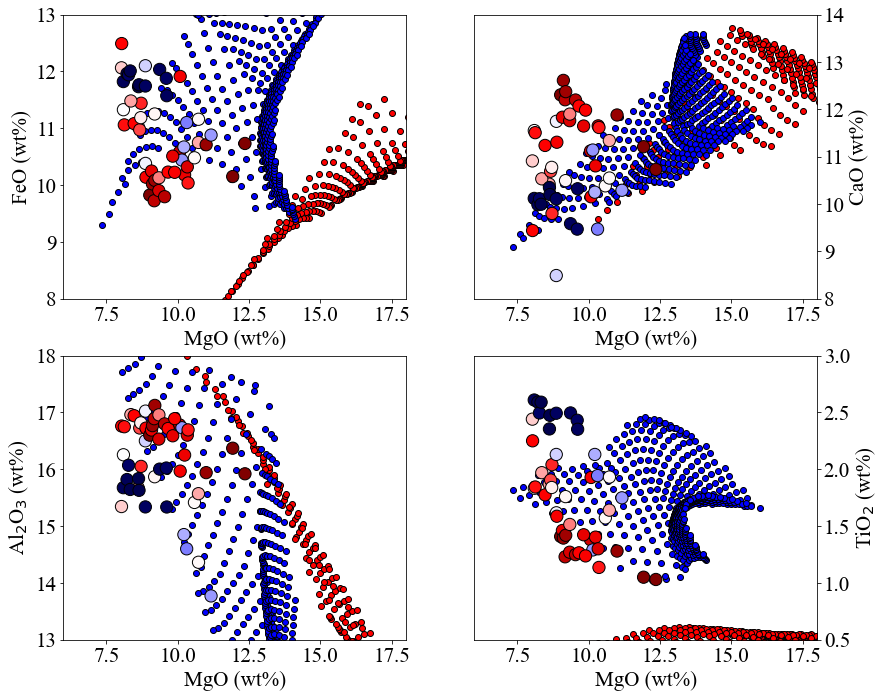

In [8]:
# focus in on Santiago and Santa Cruz
fig, ((ax6a,ax6b),(ax6c,ax6d)) = plt.subplots(2, 2, figsize=(13.5,11.5))
ax6a.plot(KLB1_TC.MgOwt.values[(KLB1_TC.liq<0.2) & (KLB1_TC.pressure > 17) & (KLB1_TC.pressure < 30)],KLB1_TC.FeOwt.values[(KLB1_TC.liq<0.2) & (KLB1_TC.pressure > 17) & (KLB1_TC.pressure < 30)],'ok',markerfacecolor='r')
ax6a.plot(MIX1g_TC.MgOwt.values[(MIX1g_TC.liq<0.6) & (MIX1g_TC.pressure > 17)],MIX1g_TC.FeOwt.values[(MIX1g_TC.liq<0.6) & (MIX1g_TC.pressure > 17)],'ok',markerfacecolor='b')
ax6a.scatter(Filt.MgO[(Filt.Loc=="Santiago")|(Filt.Loc=="Rabida")|(Filt.Loc=="Santa Cruz")|(Filt.Loc=="Santa Fe")],
             Filt.FeO[(Filt.Loc=="Santiago")|(Filt.Loc=="Rabida")|(Filt.Loc=="Santa Cruz")|(Filt.Loc=="Santa Fe")],
             c=((Filt.Nb[(Filt.Loc=="Santiago")|(Filt.Loc=="Rabida")|(Filt.Loc=="Santa Cruz")|(Filt.Loc=="Santa Fe")])/Filt.Zr[(Filt.Loc=="Santiago")|(Filt.Loc=="Rabida")|(Filt.Loc=="Santa Cruz")|(Filt.Loc=="Santa Fe")]),
             marker='o',
             s=150, zorder=4,cmap='seismic_r',edgecolors='k')

ax6a.set_ylabel('FeO (wt%)')
ax6a.set_xlabel('MgO (wt%)')
ax6a.set_xlim([6,18])
ax6a.set_ylim([8,13])

ax6b.plot(KLB1_TC.MgOwt.values[(KLB1_TC.liq<0.2) & (KLB1_TC.pressure > 17) & (KLB1_TC.pressure < 30)],KLB1_TC.CaOwt.values[(KLB1_TC.liq<0.2) & (KLB1_TC.pressure > 17) & (KLB1_TC.pressure < 30)],'ok',markerfacecolor='r')
ax6b.plot(MIX1g_TC.MgOwt.values[(MIX1g_TC.liq<0.6) & (MIX1g_TC.pressure > 17)],MIX1g_TC.CaOwt.values[(MIX1g_TC.liq<0.6) & (MIX1g_TC.pressure > 17)],'ok',markerfacecolor='b')
ax6b.scatter(Filt.MgO[(Filt.Loc=="Santiago")|(Filt.Loc=="Rabida")|(Filt.Loc=="Santa Cruz")|(Filt.Loc=="Santa Fe")],
             Filt.CaO[(Filt.Loc=="Santiago")|(Filt.Loc=="Rabida")|(Filt.Loc=="Santa Cruz")|(Filt.Loc=="Santa Fe")],
             c=((Filt.Nb[(Filt.Loc=="Santiago")|(Filt.Loc=="Rabida")|(Filt.Loc=="Santa Cruz")|(Filt.Loc=="Santa Fe")])/Filt.Zr[(Filt.Loc=="Santiago")|(Filt.Loc=="Rabida")|(Filt.Loc=="Santa Cruz")|(Filt.Loc=="Santa Fe")]),
             marker='o',
             s=150, zorder=4,cmap='seismic_r',edgecolors='k')

ax6b.set_ylabel('CaO (wt%)')
ax6b.set_xlabel('MgO (wt%)')
ax6b.set_xlim([6,18])
ax6b.set_ylim([8,14])
ax6b.yaxis.set_label_position("right")
ax6b.yaxis.tick_right()

ax6c.plot(KLB1_TC.MgOwt.values[(KLB1_TC.liq<0.2) & (KLB1_TC.pressure > 17) & (KLB1_TC.pressure < 30)],KLB1_TC.Al2O3wt.values[(KLB1_TC.liq<0.2) & (KLB1_TC.pressure > 17) & (KLB1_TC.pressure < 30)],'ok',markerfacecolor='r')
ax6c.plot(MIX1g_TC.MgOwt.values[(MIX1g_TC.liq<0.6) & (MIX1g_TC.pressure > 17)],MIX1g_TC.Al2O3wt.values[(MIX1g_TC.liq<0.6) & (MIX1g_TC.pressure > 17)],'ok',markerfacecolor='b')
ax6c.scatter(Filt.MgO[(Filt.Loc=="Santiago")|(Filt.Loc=="Rabida")|(Filt.Loc=="Santa Cruz")|(Filt.Loc=="Santa Fe")],
             Filt.Al2O3[(Filt.Loc=="Santiago")|(Filt.Loc=="Rabida")|(Filt.Loc=="Santa Cruz")|(Filt.Loc=="Santa Fe")],
             c=((Filt.Nb[(Filt.Loc=="Santiago")|(Filt.Loc=="Rabida")|(Filt.Loc=="Santa Cruz")|(Filt.Loc=="Santa Fe")])/Filt.Zr[(Filt.Loc=="Santiago")|(Filt.Loc=="Rabida")|(Filt.Loc=="Santa Cruz")|(Filt.Loc=="Santa Fe")]),
             marker='o',
             s=150, zorder=4,cmap='seismic_r',edgecolors='k')

ax6c.set_ylabel('Al$_{2}$O$_{3}$ (wt%)')
ax6c.set_xlabel('MgO (wt%)')
ax6c.set_xlim([6,18])
ax6c.set_ylim([13,18])

ax6d.plot(KLB1_TC.MgOwt.values[(KLB1_TC.liq<0.2) & (KLB1_TC.pressure > 17) & (KLB1_TC.pressure < 30)],KLB1_TC.TiO2wt.values[(KLB1_TC.liq<0.2) & (KLB1_TC.pressure > 17) & (KLB1_TC.pressure < 30)],'ok',markerfacecolor='r')
ax6d.plot(MIX1g_TC.MgOwt.values[(MIX1g_TC.liq<0.6) & (MIX1g_TC.pressure > 17)],MIX1g_TC.TiO2wt.values[(MIX1g_TC.liq<0.6) & (MIX1g_TC.pressure > 17)],'ok',markerfacecolor='b')
ax6d.scatter(Filt.MgO[(Filt.Loc=="Santiago")|(Filt.Loc=="Rabida")|(Filt.Loc=="Santa Cruz")|(Filt.Loc=="Santa Fe")],
             Filt.TiO2[(Filt.Loc=="Santiago")|(Filt.Loc=="Rabida")|(Filt.Loc=="Santa Cruz")|(Filt.Loc=="Santa Fe")],
             c=((Filt.Nb[(Filt.Loc=="Santiago")|(Filt.Loc=="Rabida")|(Filt.Loc=="Santa Cruz")|(Filt.Loc=="Santa Fe")])/Filt.Zr[(Filt.Loc=="Santiago")|(Filt.Loc=="Rabida")|(Filt.Loc=="Santa Cruz")|(Filt.Loc=="Santa Fe")]),
             marker='o',
             s=150, zorder=4,cmap='seismic_r',edgecolors='k')

ax6d.set_ylabel('TiO$_{2}$ (wt%)')
ax6d.set_xlabel('MgO (wt%)')
ax6d.set_xlim([6,18])
ax6d.set_ylim([0.5,3])
ax6d.yaxis.set_label_position("right")
ax6d.yaxis.tick_right()

plt.savefig('MajorSant.eps', format='eps')



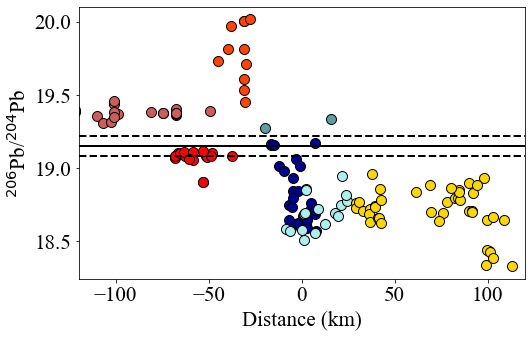

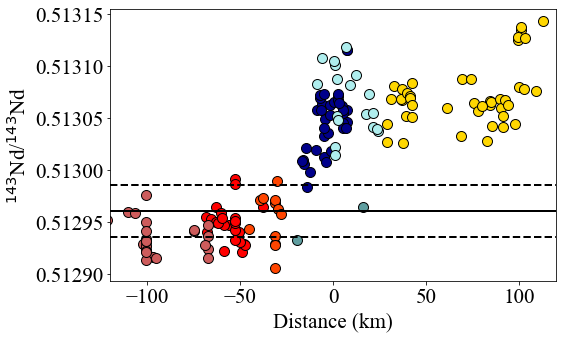

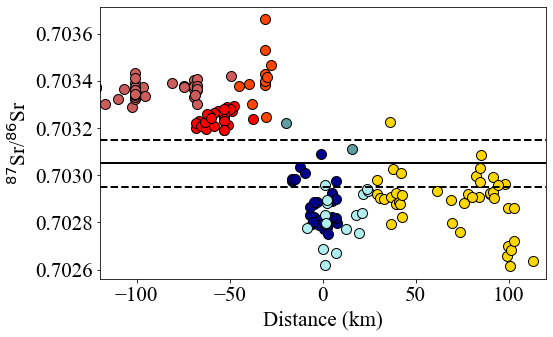

In [9]:
#Isotope longitudinal plots
fig, ((ax8a)) = plt.subplots(1, 1, figsize=(8,5))
ax8a.plot(-Comp.Dis[(Comp.Loc=="Santiago")|(Comp.Loc=="Rabida")],Comp.Pb206[(Comp.Loc=="Santiago")|(Comp.Loc=="Rabida")],'ok',markerfacecolor=Santiago1,markersize=10)
ax8a.plot(-Comp.Dis[(Comp.Loc=="Santa Cruz")|(Comp.Loc=="Santa Fe")],Comp.Pb206[(Comp.Loc=="Santa Cruz")|(Comp.Loc=="Santa Fe")],'ok',markerfacecolor=SantaCruz,markersize=10)
ax8a.plot(-Comp.Dis[Comp.Loc=="Fernandina"],Comp.Pb206[Comp.Loc=="Fernandina"],'ok',markerfacecolor=Fernandina,markersize=10)
ax8a.plot(-Comp.Dis[(Comp.Loc=="San Cristobal")|(Comp.Loc=="Espanola")|(Comp.Loc=="Genovesa")],Comp.Pb206[(Comp.Loc=="San Cristobal")|(Comp.Loc=="Espanola")|(Comp.Loc=="Genovesa")],'ok',markerfacecolor=East,markersize=10)
ax8a.plot(-Comp.Dis[(Comp.Loc=="Sierra Negra")|(Comp.Loc=="Cerro Azul")],Comp.Pb206[(Comp.Loc=="Cerro Azul")|(Comp.Loc=="Sierra Negra")],'ok',markerfacecolor=SouthernIsabela,markersize=10)
ax8a.plot(-Comp.Dis[(Comp.Loc=="Roca")|(Comp.Loc=="Ecuador")],Comp.Pb206[(Comp.Loc=="Roca")|(Comp.Loc=="Ecuador")],'ok',markerfacecolor=NorthernIsabela,markersize=10)
ax8a.plot(-Comp.Dis[(Comp.Loc=="Floreana")],Comp.Pb206[(Comp.Loc=="Floreana")],'ok',markerfacecolor=Floreana,markersize=10)

ax8a.plot([-120,120],[19.15,19.15],'-k',linewidth=2)
ax8a.plot([-120,120],[19.22,19.22],'--k',linewidth=2)
ax8a.plot([-120,120],[19.08,19.08],'--k',linewidth=2)

ax8a.set_ylabel('$^{206}$Pb/$^{204}$Pb')
ax8a.set_xlabel('Distance (km)')
ax8a.set_xlim([-120,120])

plt.savefig('Long_Pb206.eps', format='eps')

#Isotope longitudinal plots
fig, ((ax8b)) = plt.subplots(1, 1, figsize=(8,5))
ax8b.plot(-Comp.Dis[(Comp.Loc=="Santiago")|(Comp.Loc=="Rabida")],Comp.Nd143[(Comp.Loc=="Santiago")|(Comp.Loc=="Rabida")],'ok',markerfacecolor=Santiago1,markersize=10)
ax8b.plot(-Comp.Dis[(Comp.Loc=="Santa Cruz")|(Comp.Loc=="Santa Fe")],Comp.Nd143[(Comp.Loc=="Santa Cruz")|(Comp.Loc=="Santa Fe")],'ok',markerfacecolor=SantaCruz,markersize=10)
ax8b.plot(-Comp.Dis[Comp.Loc=="Fernandina"],Comp.Nd143[Comp.Loc=="Fernandina"],'ok',markerfacecolor=Fernandina,markersize=10)
ax8b.plot(-Comp.Dis[(Comp.Loc=="San Cristobal")|(Comp.Loc=="Espanola")|(Comp.Loc=="Genovesa")],Comp.Nd143[(Comp.Loc=="San Cristobal")|(Comp.Loc=="Espanola")|(Comp.Loc=="Genovesa")],'ok',markerfacecolor=East,markersize=10)
ax8b.plot(-Comp.Dis[(Comp.Loc=="Sierra Negra")|(Comp.Loc=="Cerro Azul")],Comp.Nd143[(Comp.Loc=="Cerro Azul")|(Comp.Loc=="Sierra Negra")],'ok',markerfacecolor=SouthernIsabela,markersize=10)
ax8b.plot(-Comp.Dis[(Comp.Loc=="Roca")|(Comp.Loc=="Ecuador")],Comp.Nd143[(Comp.Loc=="Roca")|(Comp.Loc=="Ecuador")],'ok',markerfacecolor=NorthernIsabela,markersize=10)
ax8b.plot(-Comp.Dis[(Comp.Loc=="Floreana")],Comp.Nd143[(Comp.Loc=="Floreana")],'ok',markerfacecolor=Floreana,markersize=10)

ax8b.plot([-120,120],[0.51296,0.51296],'-k',linewidth=2)
ax8b.plot([-120,120],[0.512935,0.512935],'--k',linewidth=2)
ax8b.plot([-120,120],[0.512985,0.512985],'--k',linewidth=2)

ax8b.set_ylabel('$^{143}$Nd/$^{143}$Nd')
ax8b.set_xlabel('Distance (km)')
ax8b.set_xlim([-120,120])

plt.savefig('Long_Nd143.eps', format='eps')

NbY=(Filt.Nb.values)/(Filt.Y.values)
NbY[(NbY > 1.5)] = np.nan
#FeMn[FeMn < 45] = np.nan
Filt['NbY']=NbY

# plot longitudina plots
fig, ((ax9a)) = plt.subplots(1, 1, figsize=(8,5))
ax9a.plot(-Comp.Dis[(Comp.Loc=="Santiago")|(Comp.Loc=="Rabida")],Comp.Sr87[(Comp.Loc=="Santiago")|(Comp.Loc=="Rabida")],'ok',markerfacecolor=Santiago1,markersize=10)
ax9a.plot(-Comp.Dis[(Comp.Loc=="Santa Cruz")|(Comp.Loc=="Santa Fe")],Comp.Sr87[(Comp.Loc=="Santa Cruz")|(Comp.Loc=="Santa Fe")],'ok',markerfacecolor=SantaCruz,markersize=10)
ax9a.plot(-Comp.Dis[Comp.Loc=="Fernandina"],Comp.Sr87[Comp.Loc=="Fernandina"],'ok',markerfacecolor=Fernandina,markersize=10)
ax9a.plot(-Comp.Dis[(Comp.Loc=="San Cristobal")|(Comp.Loc=="Espanola")|(Comp.Loc=="Genovesa")],Comp.Sr87[(Comp.Loc=="San Cristobal")|(Comp.Loc=="Espanola")|(Comp.Loc=="Genovesa")],'ok',markerfacecolor=East,markersize=10)
ax9a.plot(-Comp.Dis[(Comp.Loc=="Sierra Negra")|(Comp.Loc=="Cerro Azul")],Comp.Sr87[(Comp.Loc=="Cerro Azul")|(Comp.Loc=="Sierra Negra")],'ok',markerfacecolor=SouthernIsabela,markersize=10)
ax9a.plot(-Comp.Dis[(Comp.Loc=="Roca")|(Comp.Loc=="Ecuador")],Comp.Sr87[(Comp.Loc=="Roca")|(Comp.Loc=="Ecuador")],'ok',markerfacecolor=NorthernIsabela,markersize=10)
ax9a.plot(-Comp.Dis[(Comp.Loc=="Floreana")],Comp.Sr87[(Comp.Loc=="Floreana")],'ok',markerfacecolor=Floreana,markersize=10)

ax9a.plot([-120,120],[0.70305,0.70305],'-k',linewidth=2)
ax9a.plot([-120,120],[0.70315,0.70315],'--k',linewidth=2)
ax9a.plot([-120,120],[0.70295,0.70295],'--k',linewidth=2)

ax9a.set_ylabel('$^{87}$Sr/$^{86}$Sr')
ax9a.set_xlabel('Distance (km)')
ax9a.set_xlim([-120,120])

plt.savefig('Long_Sr87.eps', format='eps')

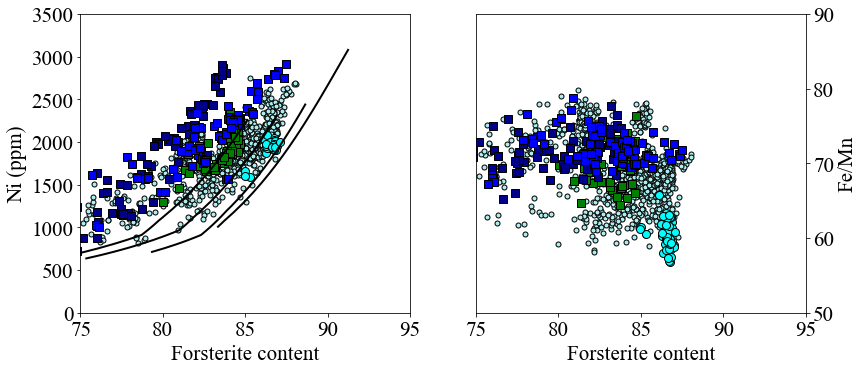

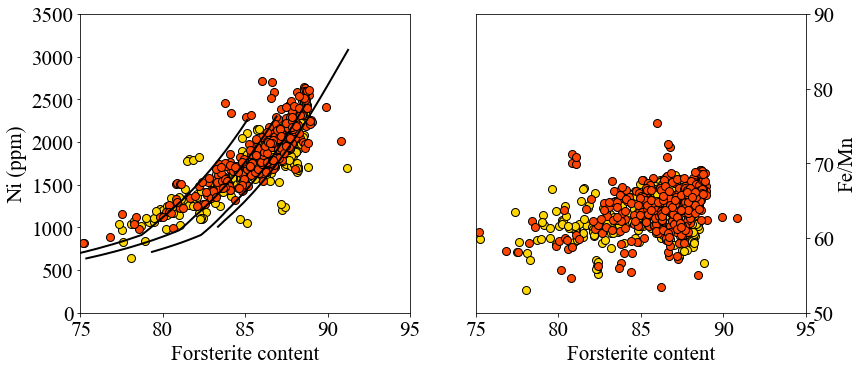

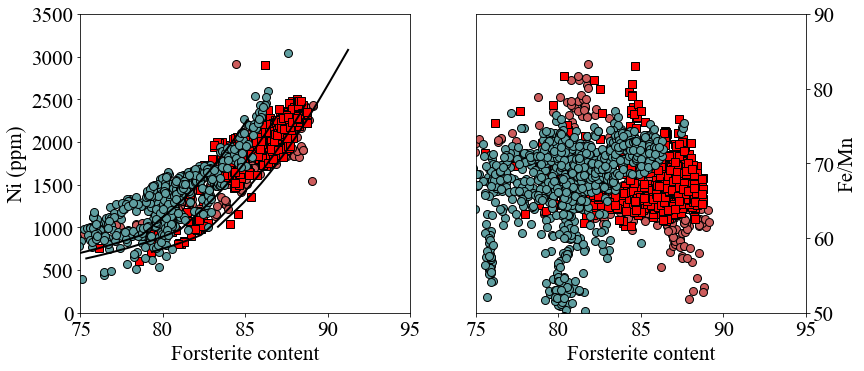

In [10]:
# plot olivine data
fig, ((ax10a,ax10b)) = plt.subplots(1, 2, figsize=(13,5.5))
ax10a.plot(Ol.Fo[Ol.Loc=="Santa Cruz"],Ol.Ni[Ol.Loc=="Santa Cruz"],'ok',markersize=5,markerfacecolor=SantaCruz)
ax10a.plot(Ol.Fo[(Ol.Loc=="Santiago")&(Ol.Sample=="07DSG75")],Ol.Ni[(Ol.Loc=="Santiago")&(Ol.Sample=="07DSG75")],'ok',markersize=8,markerfacecolor=Santiago2)
ax10a.plot(Ol.Fo[(Ol.Loc=="Santiago")&(Ol.Sample=="07DSG61")],Ol.Ni[(Ol.Loc=="Santiago")&(Ol.Sample=="07DSG61")],'sk',markersize=8,markerfacecolor='green')
ax10a.plot(Ol.Fo[(Ol.Loc=="Santiago")&(Ol.Sample=="08DSG33")],Ol.Ni[(Ol.Loc=="Santiago")&(Ol.Sample=="08DSG33")],'sk',markersize=8,markerfacecolor='darkblue')
ax10a.plot(Ol.Fo[(Ol.Loc=="Santiago")&(Ol.Ref=="Vidito")],Ol.Ni[(Ol.Loc=="Santiago")&(Ol.Ref=="Vidito")],'sk',markersize=8,markerfacecolor='blue')
ax10a.plot(OlModel.Fo[OlModel.Period=="one"],OlModel.Ni[OlModel.Period=="one"],'-k',linewidth=2)
ax10a.plot(OlModel.Fo[OlModel.Period=="two"],OlModel.Ni[OlModel.Period=="two"],'-k',linewidth=2)
ax10a.plot(OlModel.Fo[OlModel.Period=="three"],OlModel.Ni[OlModel.Period=="three"],'-k',linewidth=2)
ax10a.plot(OlModel.Fo[OlModel.Period=="four"],OlModel.Ni[OlModel.Period=="four"],'-k',linewidth=2)

ax10a.set_xlim([75,95])
ax10a.set_ylim([0,3500])
ax10a.set_ylabel('Ni (ppm)')
ax10a.set_xlabel('Forsterite content')

ax10b.plot(Ol.Fo[Ol.Loc=="Santa Cruz"],Ol.FeMn[Ol.Loc=="Santa Cruz"],'ok',markersize=5,markerfacecolor=SantaCruz)
ax10b.plot(Ol.Fo[(Ol.Loc=="Santiago")&(Ol.Sample=="07DSG75")],Ol.FeMn[(Ol.Loc=="Santiago")&(Ol.Sample=="07DSG75")],'ok',markersize=8,markerfacecolor=Santiago2)
ax10b.plot(Ol.Fo[(Ol.Loc=="Santiago")&(Ol.Sample=="07DSG61")],Ol.FeMn[(Ol.Loc=="Santiago")&(Ol.Sample=="07DSG61")],'sk',markersize=8,markerfacecolor='green')
ax10b.plot(Ol.Fo[(Ol.Loc=="Santiago")&(Ol.Sample=="08DSG33")],Ol.FeMn[(Ol.Loc=="Santiago")&(Ol.Sample=="08DSG33")],'sk',markersize=8,markerfacecolor='darkblue')
ax10b.plot(Ol.Fo[(Ol.Loc=="Santiago")&(Ol.Ref=="Vidito")],Ol.FeMn[(Ol.Loc=="Santiago")&(Ol.Ref=="Vidito")],'sk',markersize=8,markerfacecolor='blue')

ax10b.set_xlim([75,95])
ax10b.set_ylim([50,90])
ax10b.set_ylabel('Fe/Mn')
ax10b.set_xlabel('Forsterite content')
ax10b.yaxis.set_label_position("right")
ax10b.yaxis.tick_right()

plt.savefig('Ol_Central.eps', format='eps')

# plot olivine data
fig, ((ax10c,ax10d)) = plt.subplots(1, 2, figsize=(13,5.5))
ax10c.plot(Ol.Fo[(Ol.Loc=="San Cristobal")|(Ol.Loc=="Espanola")],Ol.Ni[(Ol.Loc=="San Cristobal")|(Ol.Loc=="Espanola")],'ok',markersize=8,markerfacecolor=East)
ax10c.plot(Ol.Fo[(Ol.Loc=="Floreana")],Ol.Ni[(Ol.Loc=="Floreana")],'ok',markersize=8,markerfacecolor=Floreana)
ax10c.plot(OlModel.Fo[OlModel.Period=="one"],OlModel.Ni[OlModel.Period=="one"],'-k',linewidth=2)
ax10c.plot(OlModel.Fo[OlModel.Period=="two"],OlModel.Ni[OlModel.Period=="two"],'-k',linewidth=2)
ax10c.plot(OlModel.Fo[OlModel.Period=="three"],OlModel.Ni[OlModel.Period=="three"],'-k',linewidth=2)
ax10c.plot(OlModel.Fo[OlModel.Period=="four"],OlModel.Ni[OlModel.Period=="four"],'-k',linewidth=2)

ax10c.set_xlim([75,95])
ax10c.set_ylim([0,3500])
ax10c.set_ylabel('Ni (ppm)')
ax10c.set_xlabel('Forsterite content')

ax10d.plot(Ol.Fo[(Ol.Loc=="San Cristobal")|(Ol.Loc=="Espanola")],Ol.FeMn[(Ol.Loc=="San Cristobal")|(Ol.Loc=="Espanola")],'ok',markersize=8,markerfacecolor=East)
ax10d.plot(Ol.Fo[(Ol.Loc=="Floreana")],Ol.FeMn[(Ol.Loc=="Floreana")],'ok',markersize=8,markerfacecolor=Floreana)

ax10d.set_xlim([75,95])
ax10d.set_ylim([50,90])
ax10d.set_ylabel('Fe/Mn')
ax10d.set_xlabel('Forsterite content')
ax10d.yaxis.set_label_position("right")
ax10d.yaxis.tick_right()

plt.savefig('Ol_East.eps', format='eps')

# plot olivine data
fig, ((ax11a,ax11b)) = plt.subplots(1, 2, figsize=(13,5.5))
ax11a.plot(Ol.Fo[(Ol.Loc=="Cerro Azul")|(Ol.Loc=="Alcedo")|(Ol.Loc=="Sierra Negra")],Ol.Ni[(Ol.Loc=="Cerro Azul")|(Ol.Loc=="Alcedo")|(Ol.Loc=="Sierra Negra")],'ok',markersize=8,markerfacecolor=SouthernIsabela)
ax11a.plot(Ol.Fo[(Ol.Loc=="Fernandina")],Ol.Ni[(Ol.Loc=="Fernandina")],'sk',markersize=8,markerfacecolor=Fernandina)
ax11a.plot(Ol.Fo[(Ol.Loc=="Volcan Wolf")|(Ol.Loc=="Roca Redonda")|(Ol.Loc=="Volcan Ecuador")|(Ol.Loc=="Volcan Darwin")],Ol.Ni[(Ol.Loc=="Volcan Wolf")|(Ol.Loc=="Roca Redonda")|(Ol.Loc=="Volcan Ecuador")|(Ol.Loc=="Volcan Darwin")],'ok',markersize=8,markerfacecolor=NorthernIsabela)
ax11a.plot(OlModel.Fo[OlModel.Period=="one"],OlModel.Ni[OlModel.Period=="one"],'-k',linewidth=2)
ax11a.plot(OlModel.Fo[OlModel.Period=="two"],OlModel.Ni[OlModel.Period=="two"],'-k',linewidth=2)
ax11a.plot(OlModel.Fo[OlModel.Period=="three"],OlModel.Ni[OlModel.Period=="three"],'-k',linewidth=2)
ax11a.plot(OlModel.Fo[OlModel.Period=="four"],OlModel.Ni[OlModel.Period=="four"],'-k',linewidth=2)

ax11a.set_xlim([75,95])
ax11a.set_ylim([0,3500])
ax11a.set_ylabel('Ni (ppm)')
ax11a.set_xlabel('Forsterite content')

ax11b.plot(Ol.Fo[(Ol.Loc=="Cerro Azul")|(Ol.Loc=="Alcedo")|(Ol.Loc=="Sierra Negra")],Ol.FeMn[(Ol.Loc=="Cerro Azul")|(Ol.Loc=="Alcedo")|(Ol.Loc=="Sierra Negra")],'ok',markersize=8,markerfacecolor=SouthernIsabela)
ax11b.plot(Ol.Fo[(Ol.Loc=="Fernandina")],Ol.FeMn[(Ol.Loc=="Fernandina")],'sk',markersize=8,markerfacecolor=Fernandina)
ax11b.plot(Ol.Fo[(Ol.Loc=="Volcan Wolf")|(Ol.Loc=="Roca Redonda")|(Ol.Loc=="Volcan Ecuador")|(Ol.Loc=="Volcan Darwin")],Ol.FeMn[(Ol.Loc=="Volcan Wolf")|(Ol.Loc=="Roca Redonda")|(Ol.Loc=="Volcan Ecuador")|(Ol.Loc=="Volcan Darwin")],'ok',markersize=8,markerfacecolor=NorthernIsabela)

ax11b.set_xlim([75,95])
ax11b.set_ylim([50,90])
ax11b.set_ylabel('Fe/Mn')
ax11b.set_xlabel('Forsterite content')
ax11b.yaxis.set_label_position("right")
ax11b.yaxis.tick_right()

plt.savefig('Ol_West.eps', format='eps')

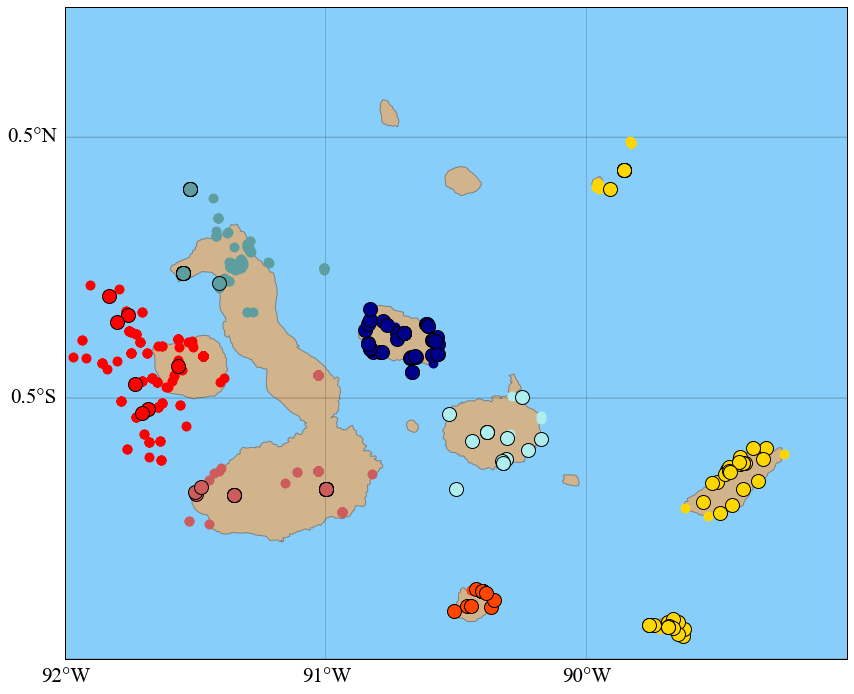

In [11]:
# define map extent
lllon = -92
lllat = -1.5
urlon = -89
urlat = 1

fig = plt.figure(figsize=(15, 12))
# Set up Basemap instance
m = Basemap(
    projection = 'merc',
    llcrnrlon = lllon, llcrnrlat = lllat, urcrnrlon = urlon, urcrnrlat = urlat,
    resolution='h')

#transform
Filt['projected_lon'], Filt['projected_lat'] = m(*(Filt.Long.values, Filt.Lat.values))

# grid data
numcols, numrows = 1000, 1000
xi = np.linspace(Filt['projected_lon'].min(), Filt['projected_lon'].max(), numcols)
yi = np.linspace(Filt['projected_lat'].min(), Filt['projected_lat'].max(), numrows)
xi, yi = np.meshgrid(xi, yi)

# interpolate
x, y, z = Filt['projected_lon'].values, Filt['projected_lat'].values, Filt.FeO.values
arr=np.array([x,y])
arr=arr.reshape(len(x),2)
zi = griddata(arr, z, (xi, yi), method='cubic')

# draw map
m.drawcoastlines(color='gray')
m.drawmapboundary(fill_color='lightskyblue')
m.fillcontinents(color='tan',lake_color='lightskyblue')

m.drawparallels(
    np.arange(lllat, urlat, 1),
    color = 'black', linewidth = 0.5,
    labels=[True, False, False, False])
m.drawmeridians(
    np.arange(lllon, urlon, 1),
    color = '0.25', linewidth = 0.5,
    labels=[False, False, False, True])

X=np.array([-91.75,-89.25])
Y=-0.6*X+(0.25-(0.6*91.75))

a=m.plot(X,Y,'-k',zorder=10)

sc=m.plot(Comp['projected_lon'][(Comp.Loc=="Santiago")|(Comp.Loc=="Rabida")],
    Comp['projected_lat'][(Comp.Loc=="Santiago")|(Comp.Loc=="Rabida")],'o',markeredgecolor='None',
    markerfacecolor=Santiago1,markersize=10,zorder=10)
sc=m.plot(Comp['projected_lon'][(Comp.Loc=="Santa Cruz")|(Comp.Loc=="Santa Fe")],
    Comp['projected_lat'][(Comp.Loc=="Santa Cruz")|(Comp.Loc=="Santa Fe")],'o',markeredgecolor='None',
    markerfacecolor=SantaCruz,markersize=10,zorder=10)
sc=m.plot(Comp['projected_lon'][Comp.Loc=="Fernandina"],
    Comp['projected_lat'][Comp.Loc=="Fernandina"],'o',markeredgecolor='None',
    markerfacecolor=Fernandina,markersize=10,zorder=10)
sc=m.plot(Comp['projected_lon'][(Comp.Loc=="San Cristobal")|(Comp.Loc=="Espanola")|(Comp.Loc=="Genovesa")],
    Comp['projected_lat'][(Comp.Loc=="San Cristobal")|(Comp.Loc=="Espanola")|(Comp.Loc=="Genovesa")],'o',markeredgecolor='None',
    markerfacecolor=East,markersize=10,zorder=10)
sc=m.plot(Comp['projected_lon'][(Comp.Loc=="Cerro Azul")|(Comp.Loc=="Sierra Negra")|(Comp.Loc=="Alcedo")],
    Comp['projected_lat'][(Comp.Loc=="Cerro Azul")|(Comp.Loc=="Sierra Negra")|(Comp.Loc=="Alcedo")],'o',markeredgecolor='None',
    markerfacecolor=SouthernIsabela,markersize=10,zorder=10)
sc=m.plot(Comp['projected_lon'][(Comp.Loc=="Roca")|(Comp.Loc=="Ecuador")|(Comp.Loc=="Wolf Volcano")|(Comp.Loc=="Darwin")],
    Comp['projected_lat'][(Comp.Loc=="Roca")|(Comp.Loc=="Ecuador")|(Comp.Loc=="Wolf Volcano")|(Comp.Loc=="Darwin")],'o',markeredgecolor='None',
    markerfacecolor=NorthernIsabela,markersize=10,zorder=10)
sc=m.plot(Comp['projected_lon'][Comp.Loc=="Floreana"],
    Comp['projected_lat'][Comp.Loc=="Floreana"],'o',markeredgecolor='None',
    markerfacecolor=Floreana,markersize=10,zorder=10)

sc=m.plot(Filt['projected_lon'][(Filt.Loc=="Santiago")|(Filt.Loc=="Rabida")],
    Filt['projected_lat'][(Filt.Loc=="Santiago")|(Filt.Loc=="Rabida")],'o',markeredgecolor='k',
    markerfacecolor=Santiago1,markersize=14,zorder=10)
sc=m.plot(Filt['projected_lon'][(Filt.Loc=="Santa Cruz")|(Filt.Loc=="Santa Fe")],
    Filt['projected_lat'][(Filt.Loc=="Santa Cruz")|(Filt.Loc=="Santa Fe")],'o',markeredgecolor='k',
    markerfacecolor=SantaCruz,markersize=14,zorder=10)
sc=m.plot(Filt['projected_lon'][Filt.Loc=="Fernandina"],
    Filt['projected_lat'][Filt.Loc=="Fernandina"],'o',markeredgecolor='k',
    markerfacecolor=Fernandina,markersize=14,zorder=10)
sc=m.plot(Filt['projected_lon'][(Filt.Loc=="San Cristobal")|(Filt.Loc=="Espanola")|(Filt.Loc=="Genovesa")],
    Filt['projected_lat'][(Filt.Loc=="San Cristobal")|(Filt.Loc=="Espanola")|(Filt.Loc=="Genovesa")],'o',markeredgecolor='k',
    markerfacecolor=East,markersize=14,zorder=10)
sc=m.plot(Filt['projected_lon'][(Filt.Loc=="Cerro Azul")|(Filt.Loc=="Sierra Negra")|(Filt.Loc=="Alcedo")],
    Filt['projected_lat'][(Filt.Loc=="Cerro Azul")|(Filt.Loc=="Sierra Negra")|(Filt.Loc=="Alcedo")],'o',markeredgecolor='k',
    markerfacecolor=SouthernIsabela,markersize=14,zorder=10)
sc=m.plot(Filt['projected_lon'][(Filt.Loc=="Roca")|(Filt.Loc=="Ecuador")|(Filt.Loc=="Wolf Volcano")|(Filt.Loc=="Darwin")],
    Filt['projected_lat'][(Filt.Loc=="Roca")|(Filt.Loc=="Ecuador")|(Filt.Loc=="Wolf Volcano")|(Filt.Loc=="Darwin")],'o',markeredgecolor='k',
    markerfacecolor=NorthernIsabela,markersize=14,zorder=10)
sc=m.plot(Filt['projected_lon'][Filt.Loc=="Floreana"],
    Filt['projected_lat'][Filt.Loc=="Floreana"],'o',markeredgecolor='k',
    markerfacecolor=Floreana,markersize=14,zorder=10)

plt.savefig('Map_Empty.eps', format='eps')

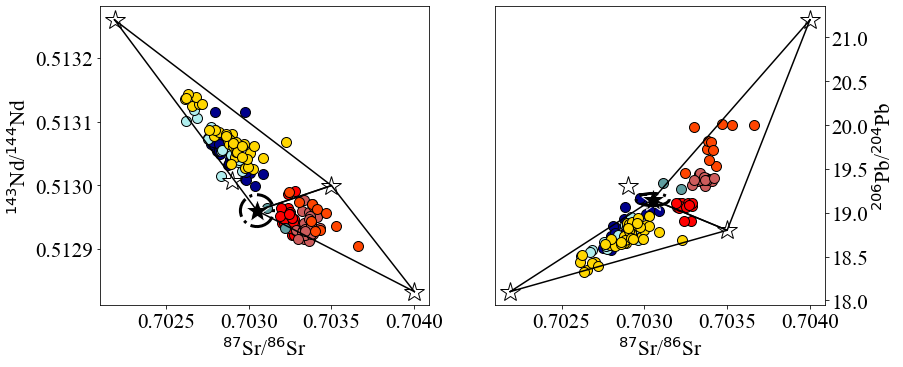

In [12]:
# isotope vs isotope plots Sr vs Nd and Sr vs Pb
from matplotlib.patches import Ellipse

Sr=np.array([0.704,0.7035,0.7029,0.70219])
Nd=np.array([3.8,7.05,7.2,12.13])
Nd=(Nd/10000)*0.512638+0.512638
Pb=np.array([21.2,18.8,19.3,18.1])

Sr2=np.array([0.7045,0.70328,0.7029,0.70243])
Nd2=np.array([3.8,5,7.2,10.4])
Nd2=(Nd2/10000)*0.512638+0.512638
Pb2=np.array([21.2,18.9,19.3,18.1])

# plot olivine data
fig, ((ax13a,ax13b)) = plt.subplots(1, 2, figsize=(13,5.5))
ax13a.plot(Comp.Sr87[(Comp.Loc=="Santiago")|(Comp.Loc=="Rabida")],Comp.Nd143[(Comp.Loc=="Santiago")|(Comp.Loc=="Rabida")],'ok',markerfacecolor=Santiago1,markersize=10)
ax13a.plot(Comp.Sr87[(Comp.Loc=="Santa Cruz")|(Comp.Loc=="Santa Fe")],Comp.Nd143[(Comp.Loc=="Santa Cruz")|(Comp.Loc=="Santa Fe")],'ok',markerfacecolor=SantaCruz,markersize=10)
ax13a.plot(Comp.Sr87[Comp.Loc=="Fernandina"],Comp.Nd143[Comp.Loc=="Fernandina"],'ok',markerfacecolor=Fernandina,markersize=10)
ax13a.plot(Comp.Sr87[(Comp.Loc=="San Cristobal")|(Comp.Loc=="Espanola")|(Comp.Loc=="Genovesa")],Comp.Nd143[(Comp.Loc=="San Cristobal")|(Comp.Loc=="Espanola")|(Comp.Loc=="Genovesa")],'ok',markerfacecolor=East,markersize=10)
ax13a.plot(Comp.Sr87[(Comp.Loc=="Sierra Negra")|(Comp.Loc=="Cerro Azul")],Comp.Nd143[(Comp.Loc=="Cerro Azul")|(Comp.Loc=="Sierra Negra")],'ok',markerfacecolor=SouthernIsabela,markersize=10)
ax13a.plot(Comp.Sr87[(Comp.Loc=="Roca")|(Comp.Loc=="Ecuador")],Comp.Nd143[(Comp.Loc=="Roca")|(Comp.Loc=="Ecuador")],'ok',markerfacecolor=NorthernIsabela,markersize=10)
ax13a.plot(Comp.Sr87[(Comp.Loc=="Floreana")],Comp.Nd143[(Comp.Loc=="Floreana")],'ok',markerfacecolor=Floreana,markersize=10)
ax13a.plot(Sr,Nd,'*k',markerfacecolor='white',markersize=20)
# ax13a.plot(Sr2,Nd2,'*k',markerfacecolor=[0.3,0.3,0.3],markersize=20)
ax13a.plot(0.70305,0.51296,'*w',markerfacecolor='black',markersize=25)
ellipse=Ellipse(xy=(0.70305,0.51296),width=0.0002,height=0.00005,linestyle='-.',edgecolor='k',fc='none',linewidth=3)
ax13a.add_patch(ellipse)
ax13a.plot(np.array([Sr[0],Sr[1],0.70305,Sr[0]]),np.array([Nd[0],Nd[1],0.51296,Nd[0]]),'-k')
ax13a.plot(np.array([Sr[3],Sr[1],0.70305,Sr[3]]),np.array([Nd[3],Nd[1],0.51296,Nd[3]]),'-k')
ax13a.set_ylabel('$^{143}$Nd/$^{144}$Nd')
ax13a.set_xlabel('$^{87}$Sr/$^{86}$Sr')


ax13b.plot(Comp.Sr87[(Comp.Loc=="Santiago")|(Comp.Loc=="Rabida")],Comp.Pb206[(Comp.Loc=="Santiago")|(Comp.Loc=="Rabida")],'ok',markerfacecolor=Santiago1,markersize=10)
ax13b.plot(Comp.Sr87[(Comp.Loc=="Santa Cruz")|(Comp.Loc=="Santa Fe")],Comp.Pb206[(Comp.Loc=="Santa Cruz")|(Comp.Loc=="Santa Fe")],'ok',markerfacecolor=SantaCruz,markersize=10)
ax13b.plot(Comp.Sr87[Comp.Loc=="Fernandina"],Comp.Pb206[Comp.Loc=="Fernandina"],'ok',markerfacecolor=Fernandina,markersize=10)
ax13b.plot(Comp.Sr87[(Comp.Loc=="San Cristobal")|(Comp.Loc=="Espanola")|(Comp.Loc=="Genovesa")],Comp.Pb206[(Comp.Loc=="San Cristobal")|(Comp.Loc=="Espanola")|(Comp.Loc=="Genovesa")],'ok',markerfacecolor=East,markersize=10)
ax13b.plot(Comp.Sr87[(Comp.Loc=="Sierra Negra")|(Comp.Loc=="Cerro Azul")],Comp.Pb206[(Comp.Loc=="Cerro Azul")|(Comp.Loc=="Sierra Negra")],'ok',markerfacecolor=SouthernIsabela,markersize=10)
ax13b.plot(Comp.Sr87[(Comp.Loc=="Roca")|(Comp.Loc=="Ecuador")],Comp.Pb206[(Comp.Loc=="Roca")|(Comp.Loc=="Ecuador")],'ok',markerfacecolor=NorthernIsabela,markersize=10)
ax13b.plot(Comp.Sr87[(Comp.Loc=="Floreana")],Comp.Pb206[(Comp.Loc=="Floreana")],'ok',markerfacecolor=Floreana,markersize=10)
ax13b.plot(Sr,Pb,'*k',markerfacecolor='white',markersize=20)
# ax13b.plot(Sr2,Pb2,'*k',markerfacecolor=[0.3,0.3,0.3],markersize=20)
ax13b.plot(0.70305,19.15,'*w',markerfacecolor='black',markersize=25)
ellipse=Ellipse(xy=(0.70305,19.15),width=0.0002,height=0.14,linestyle='-.',edgecolor='k',fc='none',linewidth=3,zorder=10)
ax13b.add_patch(ellipse)
ax13b.plot(np.array([Sr[0],Sr[1],0.70305,Sr[0]]),np.array([Pb[0],Pb[1],19.15,Pb[0]]),'-k')
ax13b.plot(np.array([Sr[3],Sr[1],0.70305,Sr[3]]),np.array([Pb[3],Pb[1],19.15,Pb[3]]),'-k')
ax13b.set_ylabel('$^{206}$Pb/$^{204}$Pb')
ax13b.set_xlabel('$^{87}$Sr/$^{86}$Sr')
ax13b.yaxis.set_label_position("right")
ax13b.yaxis.tick_right()
plt.savefig('CaO_iso.eps', format='eps')



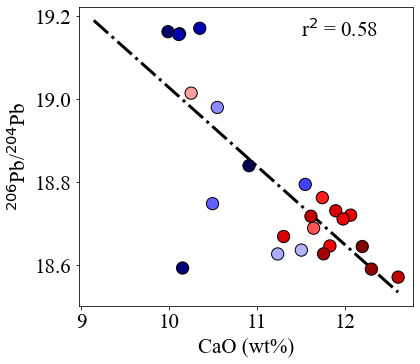

In [13]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

x=np.array(Filt.CaO[(Filt.Loc=="Santiago")|(Filt.Loc=="Rabida")])
y=np.array(Filt['Pb206'][(Filt.Loc=="Santiago")|(Filt.Loc=="Rabida")])
D=pd.DataFrame(columns=['x','y'])
D['x']=x
D['y']=y
D=D.dropna()

model = LinearRegression().fit(np.array(D['x']).reshape(-1,1), D['y'])
r_sq = model.score(np.array(D['x']).reshape(-1,1), D['y'])

x_pred=np.linspace(np.min(Filt['CaO'][(Filt.Loc=="Santiago")|(Filt.Loc=="Rabida")]),np.max(Filt['CaO'][(Filt.Loc=="Santiago")|(Filt.Loc=="Rabida")]),101)
y_pred = model.intercept_ + model.coef_ * x_pred

fig14, ((ax14a)) = plt.subplots(1, 1, figsize=(6,5.5))

ax14a.scatter(Filt.CaO[(Filt.Loc=="Santiago")|(Filt.Loc=="Rabida")],
             Filt['Pb206'][(Filt.Loc=="Santiago")|(Filt.Loc=="Rabida")],
             c=Filt.FeO[(Filt.Loc=="Santiago")|(Filt.Loc=="Rabida")],
             marker='o',alpha=1,
             s=150, zorder=4,cmap='seismic_r',edgecolors='k')
ax14a.plot(x_pred,y_pred,'-.k',linewidth=3)

ax14a.set_xlabel('CaO (wt%)')
ax14a.set_ylabel('$^{206}$Pb/$^{204}$Pb')

ax14a.text(11.5,19.15, 'r$^{2}$ = '+str(round(r_sq,2)))


plt.savefig('CaO_iso.eps', format='eps')
